# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024

In [1]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

/Users/dmnavarro/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as 

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files. 

Things to note:
- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables

In [3]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(variable="SST").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,CTRL,monthly,1.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-SS...
2,SST,potential temperature,ocn,HIST,monthly,1.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SS...
3,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [4]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members = 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="SST",
    experiment=["20C", "RCP85"],  
)

col_grid = col.search(frequency="static", component="ocn", experiment=["20C", "RCP85"])
col_grid.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
1,NaN,NaN,ocn,20C,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)

dgrid = col_grid.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)

print(f"\nDataset dictionary keys:\n {dsets.keys()}")

dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/dmnavarro/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/dmnavarro/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


{'ocn.20C.monthly': <xarray.Dataset>
 Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
 Coordinates:
   * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
   * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
     time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
   * z_t         (z_t) float32 500.0
 Dimensions without coordinates: nlat, nlon, d2
 Data variables:
     SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 384, 320), meta=np.ndarray>
 Attributes: (12/25)
     Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
     NCO:                               4.4.4
     calendar:                          All years have exactly  365 days.
     cell_methods:                      cell_methods = time: mean ==> the vari...
     contents:                          Diagnostic and Prognostic Variables
     nco_openmp_thread_

In [12]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
dg_20C = dgrid["ocn.20C.static"]
dg_RCP85 = dgrid["ocn.RCP85.static"]

ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 384, 320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

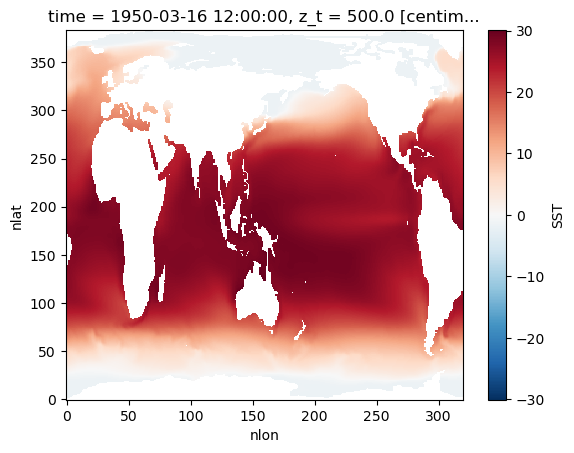

In [7]:
#this is mapping the whole world
ds_20C_mean=ds_20C.mean(dim="member_id")

test_2 = ds_20C_mean.SST.sel(time=slice("1950", "2000"))

test_1950_2 = test_2.sel(time='1950-03')
test_2000_2 = test_2.sel(time='2000-03')

test_1950_2.squeeze().plot()

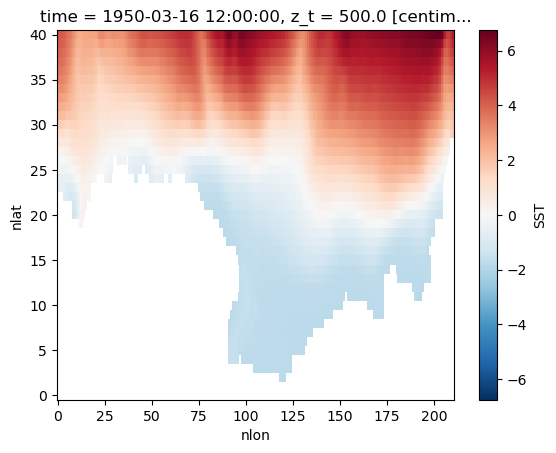

In [14]:
regbox=[-40,40,90,300]
#Then, open the xarray data you want; in the example below, I opened a file containing SST and called the xarray object "mytos". You can then generate "mask" arrays using logical statements; the arrays "mask_lon" and "mask_lat" below will be TRUE everywhere inside the region and FALSE everywhere else. The last line then uses the "where" statement to find all the data where the mask is TRUE, and drops everything else:

# Read in specified region
mask_lon = (test_1950_2.nlon >= regbox[2]) & (test_1950_2.nlon <= regbox[3])
mask_lat = (test_1950_2.nlat >= regbox[0]) & (test_1950_2.nlat <= regbox[1])
sst=test_1950_2.where(mask_lon & mask_lat, drop=True).squeeze()

sst.plot()

In [8]:
#prep to show certain part of the map
#subset the region box
#regbox=[10, 50, 150, 300]
# Read in specified region
#mask_lon = (merged_ds20C.nlat >= regbox[2]) & (merged_ds20C.nlon <= regbox[3])
#mask_lat = (merged_ds20C.nlat >= regbox[0]) & (merged_ds20C.nlon <= regbox[1])
#temp=test_1950_2.where(mask_lon.compute() & mask_lat.compute(), drop=True)
#temp

In [9]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

#grid = grid[["TLAT", "TLONG"]]

grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [10]:
#merge your datasets 
merge_dataset1= xr.merge([grid, ds_20C])

/Users/dmnavarro/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<Axes: >

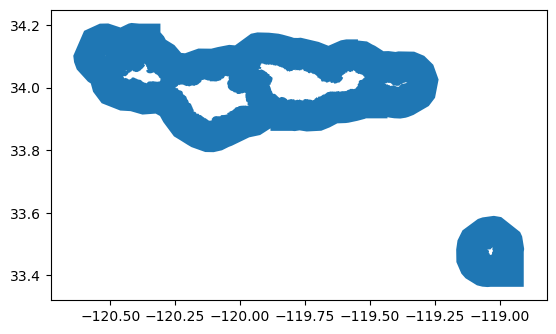

In [11]:
# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

### Example 2: CMIP6

Now I'll do the same thing for the multi-model CMIP6 database, following procedures similar to

https://github.com/pangeo-data/pangeo-cmip6-examples/blob/master/basic_search_and_load.ipynb

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

In [ ]:
# Locate monthly sea surface temperature (tos) from all simulations of the historical period
df_ta = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'historical'")
df_ta

In [ ]:
# Get only information for a specific model: say, CanESM5
df_ta_canesm5 = df_ta.query('source_id == "CanESM5"')
df_ta_canesm5

In [ ]:
# create login credentials, for accessing file system anonymously: this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [ ]:
# get all paths to the relevant datasets
zstore = df_ta_canesm5.zstore

# display them
zstore

In [ ]:
# Test data I/O by using the first entry in the data table
zstore = df_ta_canesm5.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

In [ ]:
ds.tos.sel(time='2010-03').squeeze().plot()

In [ ]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(30, 20), 
#                        subplot_kw={'projection': ccrs.PlateCarree()})

# # Plot the Xarray dataset as background
# ds_20C_mean['TEMP'].plot(ax=ax, 
#          transform=ccrs.PlateCarree())

# # Set the extent of the plot based on the shapefile bounding box
# ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# # Plot the shapefile
# #cinms_shape.plot(ax=ax, facecolor = "none")

# # Add gridlines
# ax.gridlines(draw_labels=True)

# # Add a title
# ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# # Show the plot
# plt.show()

In [ ]:
# Merge the datasets
#merged_dataset = xr.merge([grid] + list(dsets.values()))

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming ds.tos has dimensions (time, lat, lon)
tos_at_specific_time = ds.tos.sel(time='2010-03').mean(dim="time")

# Set up the plot
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
# Plot the data
tos_at_specific_time.plot.pcolormesh(ax=ax, cmap='coolwarm', x='longitude', y='latitude')
plt.title('Mean Sea Surface Temperature (March 2010)')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')

plt.show()
